# VARS annotations by depth

To **change target species**, update SQL query and prefixes.

In [1]:
## Imports

import pandas as pd
import numpy as np

import re # for extracting logon info from text file

import jaydebeapi # for connecting to VARS db
import VARS # for connecting to VARS db

from datetime import datetime # for handling dates
import pytz # for handling time zones

In [2]:
## Extract logon information from text file

# Get list of each line in file
filename = 'VARS_logon_info.txt'
f = open(filename, 'r')
lines = f.readlines()
f.close()

# Function for extracting information from lines
def get_single_quoted_text(s):
    """ 
    Takes string s and returns any text in s that is between the first set of single quotes, removing whitespace. 
    
    Example:
    s = "What if there's more ' than one' sest of single' quotes?"
    get_single_quoted_text(s) --> 's more'
    
    """
    
    extracted_text = re.search('''(?<=')\s*[^']+?\s*(?=')''', s)
    return(extracted_text.group().strip())

# Assign logon info
dr = get_single_quoted_text(lines[2])
name = get_single_quoted_text(lines[3])
pw = get_single_quoted_text(lines[4])
un = get_single_quoted_text(lines[5])
url = get_single_quoted_text(lines[6])

### Pull data

In [37]:
## Build SQL query

sql = """
        SELECT index_recorded_timestamp,
               observation_uuid,
               activity,
               concept,
               observation_group,
               observer,
               image_url,
               depth_meters,
               latitude,
               longitude,
               link_name,
               link_value,
               to_concept,
               associations,
               video_sequence_name,
               chief_scientist
        FROM annotations a
        WHERE concept LIKE 'Nanomia%'
"""

#         WHERE concept LIKE 'Nanomia%'

#         WHERE concept LIKE 'Aegina%'

#         WHERE concept LIKE 'Engraulis%'
#             OR concept LIKE 'Engraulidae'

In [38]:
## Query the database

# Get connection
conn = VARS.get_db_conn(dr, url, un, pw, name)

# Submit query
data = VARS.get_data(conn, sql)

# Close connection
conn.close()

In [39]:
## Add column names

data.rename(columns={
    0:'index_recorded_timestamp',
    1:'observation_uuid',
    2:'activity',
    3:'concept',
    4:'observation_group',
    5:'observer',
    6:'image_url',
    7:'depth_meters',
    8:'latitude',
    9:'longitude',
    10:'link_name',
    11:'link_value',
    12:'to_concept',
    13:'associations',
    14:'video_sequence_name',
    15:'chief_scientist'
}, inplace=True)

data.head()

,index_recorded_timestamp,observation_uuid,activity,concept,observation_group,observer,image_url,depth_meters,latitude,longitude,link_name,link_value,to_concept,associations,video_sequence_name,chief_scientist
0,2007-01-19 18:49:53,5EAFC62F-F9EB-4A9F-9C18-C39822C1F68F,descend,Nanomia bijuga,ROV,schlin,None,346.959991,36.704283,-122.051562,alternate timecode,23:19:05:28,self,alternate timecode | self | 23:19:05:28,Ventana 2949,Bruce Robison
1,2000-09-26 06:46:49,17BD74F5-0F2E-41CD-88F7-F9BE11CE3C18,diel transect,Nanomia bijuga,ROV,kwalz,None,299.739990,36.721924,-122.059467,alternate timecode,03:12:59:10,self,alternate timecode | self | 03:12:59:10,Ventana 1832,Bruce Robison
2,2009-02-12 17:29:27,D548DE84-C8AC-40BC-BB3C-D3361AD05C84,descend,Nanomia bijuga,ROV,lonny,http://search.mbari.org/ARCHIVE/frameGrabs/Ven...,228.850006,36.698746,-122.052755,comment,D-3,human,comment | human | D-3,Ventana 3336,Steve Haddock
3,2009-02-12 17:29:27,D548DE84-C8AC-40BC-BB3C-D3361AD05C84,descend,Nanomia bijuga,ROV,lonny,http://search.mbari.org/ARCHIVE/frameGrabs/Ven...,228.850006,36.698746,-122.052755,comment,D-3,human,comment | human | D-3,Ventana 3336,Steve Haddock
4,2007-07-11 16:51:36,911BA31A-9056-409C-9B80-2ECFA34A0E35,descend,Nanomia bijuga,ROV,sbush,http://search.mbari.org/ARCHIVE/frameGrabs/Ven...,188.309998,36.695488,-122.047270,identity-reference,3,self,identity-reference | self | 3,Ventana 3051,Bruce Robison


### Filter by proximity to M1, MARS

In [27]:
## Filter

# # Circle of radius = 9 km encompassing MARS and M1
# data['distance'] = (data['longitude'] + 122.1067)**2 + (data['latitude'] - 36.7325)**2
# data = data[data['distance'] <= 0.100899**2]

# Rectangle inshore of M1
data = data[(data['longitude'] > -122.2064) & (data['longitude'] < -121.7878)]
data = data[(data['latitude'] > 36.5994) & (data['latitude'] < 36.9811)]

### Set prefixes for output plots and data sets

In [29]:
## Set prefixes

species_queried = 'Engraulis_MontereyBay'

first_year = min(data['index_recorded_timestamp']).split('-')[0]
last_year = max(data['index_recorded_timestamp']).split('-')[0]

prefix = 'VARS_' + species_queried + '_' + first_year + '-' + last_year + '_'

### Create and save map

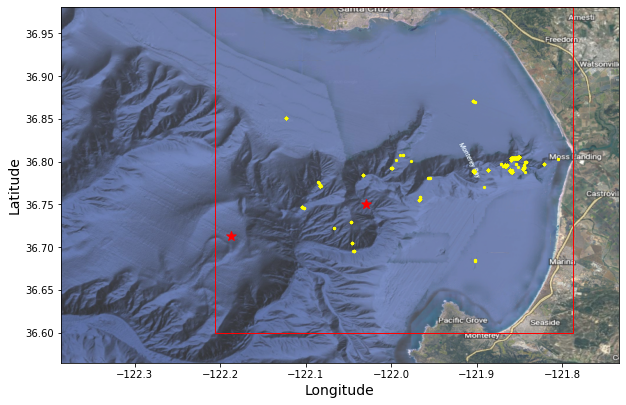

In [30]:
## Plot lat, lons

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

mars_img=mpimg.imread('Monterey Bay.png')
ax = data.plot(kind="scatter", x="longitude", y="latitude", figsize=(10, 8), color='yellow', marker='.')

plt.scatter([-122.1869, -122.03], [36.7125, 36.75], color='red', marker='*', s=100)

# # Add circle
# rect = patches.Circle((-122.1067, 36.7325), radius=0.100899, linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

# Add rectangle
rect = patches.Rectangle((-122.2064, 36.5994), 0.4186, 0.3817, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.imshow(mars_img, extent=[-122.386111, -121.7338889, 36.56472, 36.981111], alpha=0.8)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# Save
filename = prefix + 'map.png'
plt.savefig(filename)

plt.show()

### Handle dates

In [31]:
## How are these distributed across years?

# function to format dates and create month and year columns
def get_year_month(df):
    
    iso_formatted = []
    year = []
    year_month = []

    for dt in df['index_recorded_timestamp']:
    
        # Convert string to datetime
        try:
            dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S.%f') # some datetimes have milliseconds
        except ValueError:
            dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')

        # Save month and year
        year.append(dt.year)
        year_month.append(str(dt.year) + '_' + str(dt.month))

        # Assign UTC timezone
        utc = pytz.UTC
        dt = dt.astimezone(utc)

        # Put in ISO format string
        dt = dt.isoformat()

        # Save in list
        iso_formatted.append(dt)

    df['eventDate'] = iso_formatted
    df['year'] = year
    df['year_month'] = year_month
    
    return(df)
    
# format
data = get_year_month(data)

### Aggregate and plot histograms

In [32]:
## Aggregate data

# Create depth categories
depth_cat = pd.cut(data['depth_meters'], bins=range(-50, 1050, 100))
data['depth_cat'] = depth_cat

# Find numbers of annotations at each depth category for each month/year combination in the data set
ann_per_month = data.groupby(['year_month', 'depth_cat'])['concept'].count()
ann_per_month = ann_per_month.reset_index()

# Create a year column
ann_per_month['year'] = ann_per_month['year_month'].str.split('_').str[0]

# Find numbers of annotations at each depth category for each year
ann_per_year = data.groupby(['year', 'depth_cat'])['concept'].count()
ann_per_year = ann_per_year.reset_index()

# Find average number of monthly annotations at each depth category for each year
av_monthly_ann_per_year = ann_per_month.groupby(['year', 'depth_cat']).agg(
    count=('concept', 'count'),
    mean=('concept', 'mean')
)
av_monthly_ann_per_year = av_monthly_ann_per_year.reset_index()

# Find average yearly annotations at each depth category
av_yearly_ann = ann_per_year.groupby(['depth_cat']).agg(
    count=('concept', 'count'),
    mean=('concept', 'mean'),
    std=('concept', 'std')
)
av_yearly_ann = av_yearly_ann.reset_index()
av_yearly_ann['se'] = av_yearly_ann['std']/np.sqrt(av_yearly_ann['count'])

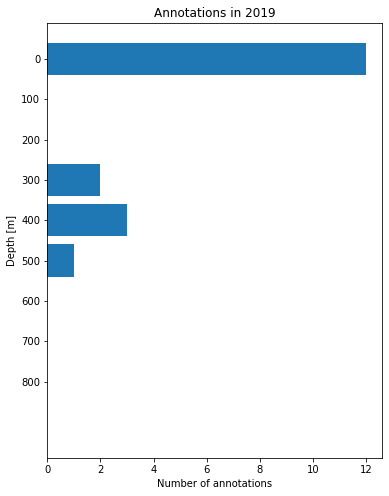

In [33]:
## Histogram for 2019

plt.figure(figsize = (6, 8))

plt.barh(range(10), ann_per_year.loc[ann_per_year['year'] == 2019, 'concept'])
plt.xlabel('Number of annotations')
plt.ylabel('Depth [m]')
plt.title('Annotations in 2019')
plt.yticks(ticks=range(9), labels=range(0, 1000, 100))
plt.gca().invert_yaxis()

# Save
filename = prefix + 'depth2019.png'
plt.savefig(filename)

plt.show()

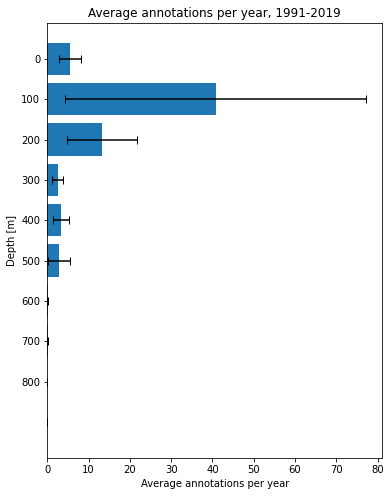

In [34]:
## Averaged across years

plt.figure(figsize = (6, 8))

plt.barh(range(10), av_yearly_ann['mean'], xerr=av_yearly_ann['se'], capsize=4)
plt.xlabel('Average annotations per year')
plt.ylabel('Depth [m]')
plt.title('Average annotations per year, ' + first_year + '-2019')
plt.yticks(ticks=range(9), labels=range(0, 1000, 100))
plt.gca().invert_yaxis()

# Save
filename = prefix + 'depth.png'
plt.savefig(filename)

plt.show()

### Plot heatmap

In [35]:
## Pivot and convert to array

pivoted = av_monthly_ann_per_year.pivot(index='depth_cat', columns='year', values='mean')
pivoted_arr = pivoted.to_numpy()

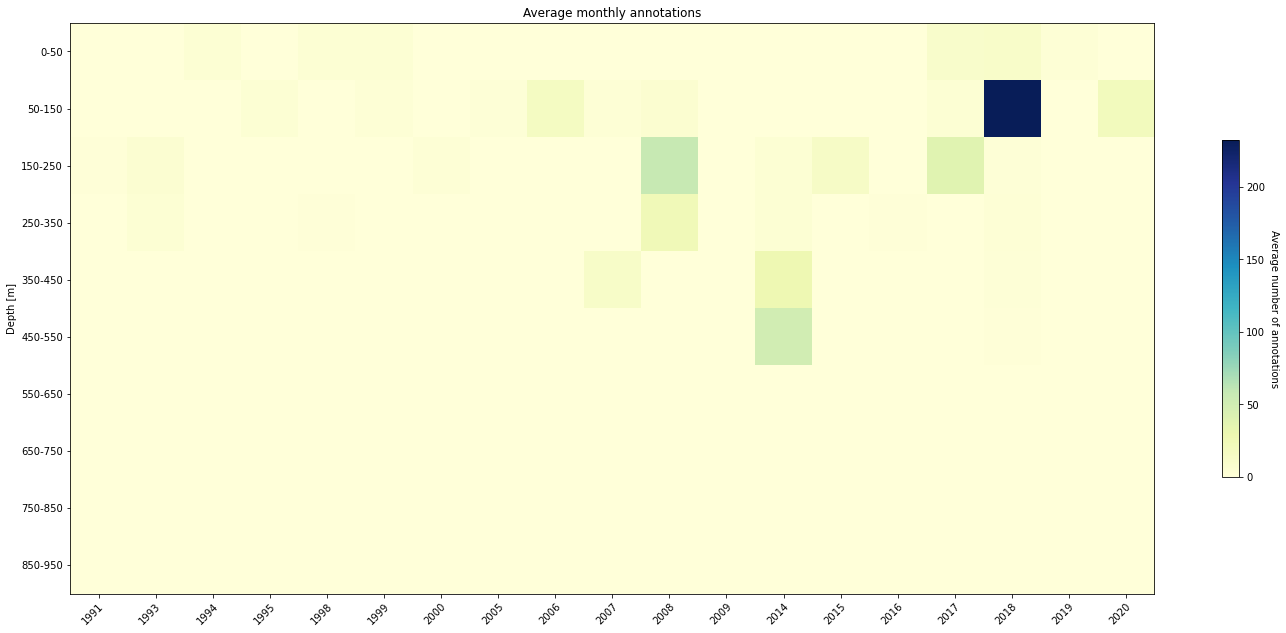

In [36]:
# Plot

years = pivoted.columns.values
depths = ['0-50', '50-150', '150-250', '250-350', '350-450', '450-550', '550-650', '650-750', '750-850', '850-950']

fig, ax = plt.subplots(figsize=(20, 12))
# fig, ax = plt.subplots(figsize=(7, 7))

im = ax.imshow(pivoted_arr, cmap='YlGnBu')

ax.set_xticks(np.arange(len(years)))
ax.set_yticks(np.arange(len(depths)))
ax.set_xticklabels(years)
ax.set_yticklabels(depths)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax, shrink=0.4)
# cbar = ax.figure.colorbar(im, ax=ax, shrink=0.5)
cbar.ax.set_ylabel('Average number of annotations', rotation=-90, va="bottom")

ax.set_title('Average monthly annotations')
ax.set_ylabel('Depth [m]')
fig.tight_layout()

# Save
filename = prefix + 'heatmap'
plt.savefig(filename)

plt.show()